# Temperature Stats Dashboard

## Goal

Create a lightweight data-analysis script that cleans and summarises daily temperature readings — introducing realistic data-science thinking (loading, cleaning, describing, visualising) while staying within approachable Python.

## Scenario
You receive a small log of daily max temperatures from weather sensors across 3 towns.
Some entries are missing, some are strings like "error" or "--", and a few are clearly unrealistic (e.g. 999 °C).

Your task is to:

1. Load & clean the readings.
2. Compute descriptive statistics (mean, median, min, max, std dev).
3. Flag potential outliers (values > mean ± 2 × std).
4. Produce a short report summarising data, health, and key stats.

## Core tasks
1. Write a function that:
   * Convert valid numbers to floats.
   * Replace invalids or out-of-range values (< -20 or > 60) with None.
   * Count how many entries were invalid.
2. Apply this cleaner to each city's list and build a new dictionary `clean_data`.
3. For each city compute:
   * mean, median, std, min, max, and n_outliers (|value–mean| > 2 × std).
   * Store results in a summary dict.
4. Print the clean data and summary neatly.
5. Add a histogram per city

## Import required packages

In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

## Create the data example

In [85]:
np.random.seed(42)
random.seed(42)

def generate_temperature_data(n=200):
    data = {}
    
    # Define city-level mean and variability (retrieve from Google - realistic!-)
    cities = {
        "Cairns": {"mean": 24.8, "std": 1},
        "Townsville": {"mean": 26, "std": 2},
        "Atherton": {"mean": 19.8, "std": 1.5}
    }
    
    for city, params in cities.items():
        mean, std = params["mean"], params["std"]
        
        # Step 1: Generate mostly valid values
        temps = np.random.normal(loc=mean, scale=std, size=n).round(1).tolist()
        
        # Step 2: Randomly inject ~10% invalid or extreme values
        n_invalid = int(0.1 * n)
        invalid_samples = random.choices(
            ["error", "", None, "N/A", 999, -100, "missing", "bad", "?", 65, -30],
            k=n_invalid
        )
        
        # Merge and shuffle
        combined = temps + invalid_samples
        random.shuffle(combined)
        data[city] = combined
    
    return data

# Generate dataset
data = generate_temperature_data(n=200)

# Confirm size
print({k: len(v) for k, v in data.items()})


{'Cairns': 220, 'Townsville': 220, 'Atherton': 220}


## Create validating function

In [79]:
def clean_temps(list_of_values):

    # Set up output
    clean_list = []
    n_invalid = 0
    
    for x in list_of_values:
        # Try to convert to number
        # If conversion was possible, check that the number is valid
        # If it is valid, added to the clean list, other wise count it as invalid
        try:
            num = float(x)
            # Check range validity
            if num < -20 or num > 60:
                n_invalid += 1
                clean_list.append(None)
            else:
                clean_list.append(num)
        except (ValueError, TypeError):
            n_invalid += 1
            clean_list.append(None)
        
        
    return clean_list, n_invalid

## Create a function to summarise the data

In [86]:
def summary_temps(data):

    data_clean = {}
    n_invalid = {}
    summary = {}
    
    for key, value in data.items():
        # Apply the clean function above
        cleaned, invalids = clean_temps(value)
        data_clean[key] = cleaned
        n_invalid[key] = invalids

        # Filter None values
        valid = [x for x in cleaned if x is not None]


        # If I have no valid values, I might run into issues when trying to compute summaries below
        if len(valid) == 0:
            # handle empty lists safely
            summary[key] = {
                'mean': None, 'median': None, 'std': None,
                'min': None, 'max': None, 'n_outliers': None,
                'n_invalid': invalids
            }
            continue

        # compute outliers
        n_outliers = sum(abs(x - np.mean(valid)) > 2 * np.std(valid) for x in valid)
        
        summary[key] = {'mean' : np.mean(valid),
                        'median' : np.median(valid),
                        'std' : np.std(valid),
                        'min' : np.min(valid),
                        'max' : np.max(valid),
                        'n_outliers' : n_outliers,
                        'n_invalid' : invalids}
    return summary
    

## Create a function to visualise the data

In [89]:
def visualise_summary(data): 
    summary = pd.DataFrame(summary_temps(data))
    summary_df = summary.T

    print("\n\t\t\t === Temperature Summary ===\n\n")
    print(summary_df)
    print("\n")


    # Create facet-style histograms
    n_cities = len(data)
    fig, axes = plt.subplots(1, n_cities, figsize=(5 * n_cities, 4), sharey=True)
    
    # If only one city, axes isn’t iterable
    if n_cities == 1:
        axes = [axes]

    for ax, (city, temps) in zip(axes, data.items()):
        # Clean and prepare valid data for plotting
        cleaned = clean_temps(temps)[0] # recycle the cleaning function
        valid = [x for x in cleaned if x is not None]
        
        ax.hist(valid, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
        ax.set_title(city)
        ax.set_xlabel("Temperature (°C)")
        ax.set_ylabel("Frequency")
        ax.axvline(summary[city]['mean'], color='red', linestyle='--', label='Mean')
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    


			 === Temperature Summary ===


               mean  median       std   min   max  n_outliers  n_invalid
Cairns      24.7630    24.8  0.931199  22.2  27.5        12.0       20.0
Townsville  26.1735    26.2  1.970139  19.5  33.7        12.0       20.0
Atherton    19.6720    19.7  1.490341  16.1  24.4         9.0       20.0




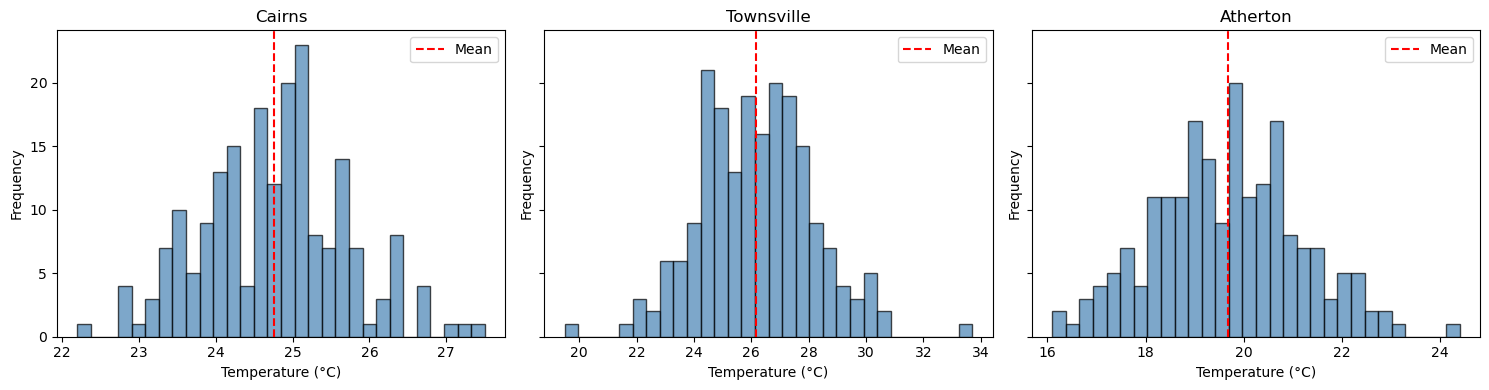

In [90]:
visualise_summary(data)

# --- End of Challenge! ---